# seismic-bumps

## 0. _Pre-processing_ 

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np

In [2]:
import sklearn
print( sklearn.__version__ )

0.20.2


In [3]:
from sklearn.preprocessing import LabelEncoder

### _0.1_ 

In [4]:
seismic_data, seismic_meta = arff.loadarff('seismic-bumps.arff')

In [5]:
seismic_bumps = pd.DataFrame(seismic_data, columns=seismic_data.dtype.fields.keys())
seismic_bumps.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,b'a',b'a',b'N',15180.0,48.0,-72.0,-72.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1,b'a',b'a',b'N',14720.0,33.0,-70.0,-79.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,b'0'
2,b'a',b'a',b'N',8050.0,30.0,-81.0,-78.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
3,b'a',b'a',b'N',28820.0,171.0,-23.0,40.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,b'0'
4,b'a',b'a',b'N',12640.0,57.0,-63.0,-52.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'


In [6]:
seismic_bumps.shape

(2584, 19)

In [7]:
seismic_bumps.get_dtype_counts()

float64    14
object      5
dtype: int64

In [8]:
seismic_bumps.isnull().sum()

seismic           0
seismoacoustic    0
shift             0
genergy           0
gpuls             0
gdenergy          0
gdpuls            0
ghazard           0
nbumps            0
nbumps2           0
nbumps3           0
nbumps4           0
nbumps5           0
nbumps6           0
nbumps7           0
nbumps89          0
energy            0
maxenergy         0
class             0
dtype: int64

In [9]:
seismic_bumps.select_dtypes(exclude=[np.float64,]).describe().T

,count,unique,top,freq
seismic,2584,2,b'a',1682
seismoacoustic,2584,3,b'a',1580
shift,2584,2,b'W',1663
ghazard,2584,3,b'a',2342
class,2584,2,b'0',2414


In [10]:
seismic_meta

Dataset: seismic-bumps
	seismic's type is nominal, range is ('a', 'b', 'c', 'd')
	seismoacoustic's type is nominal, range is ('a', 'b', 'c', 'd')
	shift's type is nominal, range is ('W', 'N')
	genergy's type is numeric
	gpuls's type is numeric
	gdenergy's type is numeric
	gdpuls's type is numeric
	ghazard's type is nominal, range is ('a', 'b', 'c', 'd')
	nbumps's type is numeric
	nbumps2's type is numeric
	nbumps3's type is numeric
	nbumps4's type is numeric
	nbumps5's type is numeric
	nbumps6's type is numeric
	nbumps7's type is numeric
	nbumps89's type is numeric
	energy's type is numeric
	maxenergy's type is numeric
	class's type is nominal, range is ('1', '0')

In [11]:
seismic_bumps['class'] = seismic_bumps['class'].astype(np.int8)

seismic_bumps['class'].value_counts(normalize=True) * 100

0    93.421053
1     6.578947
Name: class, dtype: float64

[seismic-bumps Data Set](https://archive.ics.uci.edu/ml/datasets/seismic-bumps)

( a - lack of hazard, b - low hazard, c - high hazard, d - danger state)

_Очевидно, что здесь есть отношение порядка, поэтому к соответсвующим признакам можно применить **Label encoding**_:

In [12]:
le = LabelEncoder()

for feature in ['seismic', 'seismoacoustic', 'ghazard']:
    seismic_bumps[feature] = le.fit_transform(seismic_bumps[feature])

In [13]:
seismic_bumps = pd.get_dummies(seismic_bumps, columns=['shift'], drop_first=True)

In [14]:
X, y = seismic_bumps.drop('class', 1), seismic_bumps['class']

In [15]:
X.get_dtype_counts()

int32       3
float64    14
uint8       1
dtype: int64

In [16]:
def target_encode(y):
    return (1 - 2 * y).astype(np.int8)

def target_decode(y):
    return ((1 - y) / 2).astype(np.int8)

# changing class labels to {-1;1} for the convenience of grid search for the best params of outlier detection algorithms  
y = target_encode(y)

y.value_counts()

 1    2414
-1     170
Name: class, dtype: int64

### _0.2 PCA_

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [19]:
X_scaled = X.copy()

ss = StandardScaler()

for col in X.columns:
    X_scaled[col] = ss.fit_transform(X[[col]])

print(X_scaled.shape, y.shape)

(2584, 18) (2584,)


In [20]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

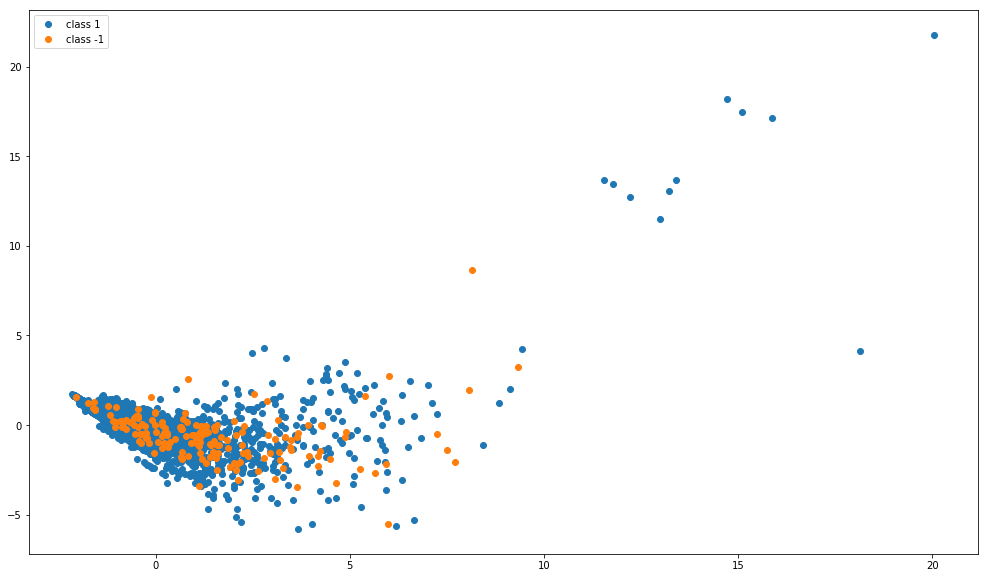

In [21]:
plt.figure(figsize=(17,10))

for u in sorted(y.unique(), reverse=True):
    ix = np.argwhere(y == u).squeeze()
    plt.plot(X_pca[ix, 0], X_pca[ix, 1], 'o', label='class {}'.format(u))

plt.legend();

In [22]:
for i, component in enumerate(pca.components_):
    print("Component #{}: {:.2f}% of initial variance".format(i + 1, 100 * pca.explained_variance_ratio_[i], 2))

Component #1: 25.31% of initial variance
Component #2: 15.37% of initial variance


## 1. _Quality metrics_

Классы сильно несбалансированы, __accuracy__ не подходит, потому что примитивно предсказывая только класс **(1)** мы получим __accuracy__ $= 93,4\%$.

Имеет смысл использовать либо __Precision__ / __Recall__ (причём настраивать модель на аномальный класс <b>(-1)</b> как на _positive_), либо __F-меру__. Причём, возможно, даже не __F1__, а __F-$\beta$__ с $\beta > 1$ (что даёт приоритет **recall**) потому что **FP**(_false positive_) в данном случае, очевидно, более приемлем, чем **FN**(_false negative_) $-$ наверное, лучше устроить ложную тревогу, чем не предупредить о землетрясении.

In [23]:
from sklearn.metrics import make_scorer

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

In [24]:
beta = 1.75

fbeta_scorer = make_scorer(fbeta_score, pos_label=-1, average='binary', beta=beta)

## 2.  _Гипотеза компактности_

_Если применить **TSNE** к не-скалированным данным, то получается довольно интересная картинка (с ленточной структурой)_.

Но, как можно по ней yвидеть (а также по визуализации **PCA** выше), по крайней мере, в пространстве двух компонент гипотеза компактности _не удовлетворена_ - классы плохо отделены друг от друга.

По этой причине можно предположить, что метрические алгоритмы классификации (**kNN**) здесь будут работать плохо. Модели линейной регрессии, судя по всему, также вряд ли смогут разделить классы.

In [25]:
from sklearn.manifold import TSNE

In [26]:
def plot_tsne(subplot, title, X, y):
    plt.subplot(subplot)
    for u in sorted(y.unique(), reverse=True):
        ix = np.argwhere(y == u).squeeze()
        plt.plot(X[ix, 0], X[ix, 1], 'o', label='class {}'.format(u))    
    plt.title(title)
    plt.legend()

In [27]:
%%time

X_embedded = TSNE(n_components=2).fit_transform(X)

Wall time: 19.2 s


In [28]:
%%time

X_scaled_embedded = TSNE(n_components=2).fit_transform(X_scaled)

Wall time: 18.3 s


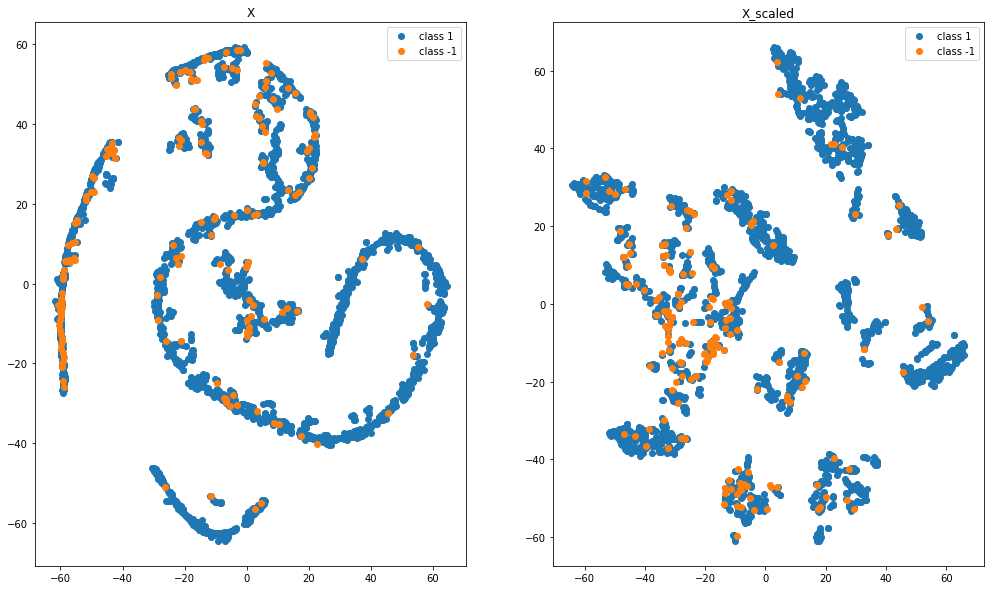

In [29]:
plt.figure(figsize=(17,10))

plot_tsne(121, 'X', X_embedded, y)
plot_tsne(122, 'X_scaled', X_scaled_embedded, y)

plt.show();

## 3.  _Simple classification attempt_

Чтобы проверить предположение из п.<b>2</b> попробуем применить для классификации как раз метод __kNN__.

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [31]:
X_scaled_emb_train, X_scaled_emb_test, X_scaled_train, X_scaled_test, X_train, X_test, y_train, y_test = \
    train_test_split(X_scaled_embedded, X_scaled, X, y, train_size=0.8, random_state=201)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2067, 18) (2067,)
(517, 18) (517,)


In [32]:
# часть тренировочного датасета, очищенная от аномалий
X_train_inliers = X_train.iloc[np.argwhere(y_train == 1).squeeze()]
X_scaled_train_inliers = X_scaled_train.iloc[np.argwhere(y_train == 1).squeeze()]

print(X_train_inliers.shape)

(1931, 18)


In [33]:
%%time

knn_grid_params = {
    'n_neighbors': list(range(1,10)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto'],
    'leaf_size': [30],
    'metric': ['minkowski'],
    'p': [2]
}

gs_knn = GridSearchCV(KNeighborsClassifier(), knn_grid_params, scoring=fbeta_scorer, cv=4, n_jobs=4)

gs_knn.fit(X_scaled_train, y_train)

Wall time: 3.96 s


In [34]:
knn_clf = gs_knn.best_estimator_

knn_clf

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [35]:
y_pred = knn_clf.predict(X_scaled_test)

In [36]:
def print_test_scoring(clf_name, y_test, y_pred, best_train_score=None):
    if not best_train_score is None:
        print('[{}] Best train score: {:.5f}'.format(clf_name, best_train_score))
        print('*' * 40)
        print()
    print('[{}] F-beta for test: {:.5f}'.format(clf_name, fbeta_score(y_test, y_pred, beta=beta, pos_label=-1)))
    print()
    print( classification_report(y_test, y_pred) )
    print('*' * 40)
    print()
    print('[{}] accuracy for test: {:.5f}'.format(clf_name, accuracy_score(y_test, y_pred)))
    print('*' * 40)

In [37]:
print_test_scoring('KNN', y_test, y_pred, gs_knn.best_score_)

[KNN] Best train score: 0.22554
****************************************

[KNN] F-beta for test: 0.28655

              precision    recall  f1-score   support

          -1       0.18      0.35      0.24        34
           1       0.95      0.89      0.92       483

   micro avg       0.85      0.85      0.85       517
   macro avg       0.57      0.62      0.58       517
weighted avg       0.90      0.85      0.87       517

****************************************

[KNN] accuracy for test: 0.85300
****************************************


Как можно видеть, результат в определении класса <b>(-1)</b>, и, в первую очередь, *__recall__*, не впечатляющий (при этом общий *__accuracy__*, как уже отмечалось, 
довольно высокий). Очевидно, что это подтверждает предположение о том, что для этого набора данных не выполняется гипотеза компактности.

## 4.  _Anomalies detection_

<i>Возможно, не совсем хорошо обучать **OneClassSVM** и **EllipticEnvelope** на датасетах, которые включают в том числе аномалии $-$ класс <b>(-1)</b>, но иначе, видимо, требуется использовать более сложную технику при кросс-валидации через grid search</i>.

In [38]:
from sklearn.model_selection import GridSearchCV

### _4.1 LOF_

In [39]:
from sklearn.neighbors import LocalOutlierFactor

In [40]:
0.01 + np.linspace(0.0, 0.3, 10)

array([0.01      , 0.04333333, 0.07666667, 0.11      , 0.14333333,
       0.17666667, 0.21      , 0.24333333, 0.27666667, 0.31      ])

In [41]:
%%time

lof = LocalOutlierFactor()

lof_grid_params = {
    'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
    'n_neighbors' : list(range(2,10)),
    'contamination' : 0.01 + np.linspace(0.0, 0.3, 10),
    'novelty' : [True]
}

gs_lof = GridSearchCV(lof, lof_grid_params, scoring=fbeta_scorer, cv=4, n_jobs=4)

gs_lof.fit(X_scaled_train, y_train)

Wall time: 1min


In [42]:
def print_precision(y_test, y_pred):
    print('Precision: [1] {:.2f}, [-1] {:.2f}'.format(1 - target_decode(y_test[y_pred == 1]).mean(),
                                                      target_decode(y_test[y_pred == -1]).mean()))

def clf_predict(clf, X_test, y_test):
    y_pred = clf.predict(X_test) # {-1, 1}
    print_precision(y_test, y_pred)
    return y_pred

In [43]:
lof_clf = gs_lof.best_estimator_

lof_clf

LocalOutlierFactor(algorithm='ball_tree', contamination=0.27666666666666667,
          leaf_size=30, metric='minkowski', metric_params=None,
          n_jobs=None, n_neighbors=2, novelty=True, p=2)

In [44]:
y_lof_pred = clf_predict(lof_clf, X_scaled_test, y_test)

Precision: [1] 0.93, [-1] 0.07


In [45]:
print_test_scoring('LOF', y_test, y_lof_pred)

[LOF] F-beta for test: 0.15800

              precision    recall  f1-score   support

          -1       0.07      0.29      0.11        34
           1       0.93      0.70      0.80       483

   micro avg       0.68      0.68      0.68       517
   macro avg       0.50      0.50      0.45       517
weighted avg       0.88      0.68      0.76       517

****************************************

[LOF] accuracy for test: 0.67698
****************************************


### _4.2 One-Class SVM_

In [46]:
from sklearn.svm import OneClassSVM

In [47]:
%%time

ocsvm = OneClassSVM()

ocsvm_grid_params = {
    'kernel' : ['poly', 'rbf', 'sigmoid'],
    'degree' : [2, 3, 5], # poly kernel only
    'gamma' : ['auto', 'scale'],
    'nu' : [0.05, 0.1, 0.2, 0.3]
}

gs_ocsvm = GridSearchCV(ocsvm, ocsvm_grid_params, scoring=fbeta_scorer, cv=4, n_jobs=4)

gs_ocsvm.fit(X_scaled_train, y_train)

Wall time: 7.98 s


In [48]:
ocsvm_clf = gs_ocsvm.best_estimator_

ocsvm_clf

OneClassSVM(cache_size=200, coef0=0.0, degree=2, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.3, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [49]:
y_ocsvm_pred = clf_predict(ocsvm_clf, X_scaled_test, y_test)

Precision: [1] 0.96, [-1] 0.13


In [50]:
print_test_scoring('OneClassSVM', y_test, y_ocsvm_pred, gs_ocsvm.best_score_)

[OneClassSVM] Best train score: 0.28415
****************************************

[OneClassSVM] F-beta for test: 0.30615

              precision    recall  f1-score   support

          -1       0.13      0.56      0.21        34
           1       0.96      0.73      0.83       483

   micro avg       0.72      0.72      0.72       517
   macro avg       0.54      0.65      0.52       517
weighted avg       0.90      0.72      0.79       517

****************************************

[OneClassSVM] accuracy for test: 0.72147
****************************************


### _4.3 IsolationForest_

In [51]:
from sklearn.ensemble import IsolationForest

In [52]:
%%time

iforest = IsolationForest()

iforest_grid_params = {
    'contamination' : np.linspace(0.0, 0.3, 10),
    'max_features' : np.linspace(0.5, 1.0, 6),
}

gs_iforest = GridSearchCV(iforest, iforest_grid_params, scoring=fbeta_scorer, cv=4, n_jobs=4)

gs_iforest.fit(X_train, y_train)

Wall time: 34.1 s


In [53]:
iforest_clf = gs_iforest.best_estimator_

iforest_clf

IsolationForest(behaviour='old', bootstrap=False, contamination=0.3,
        max_features=0.9, max_samples='auto', n_estimators=100,
        n_jobs=None, random_state=None, verbose=0)

In [54]:
y_iforest_pred = clf_predict(iforest_clf, X_test, y_test)

Precision: [1] 0.96, [-1] 0.13


In [55]:
print_test_scoring('IsolationForest', y_test, y_iforest_pred, gs_iforest.best_score_)

[IsolationForest] Best train score: 0.31964
****************************************

[IsolationForest] F-beta for test: 0.30997

              precision    recall  f1-score   support

          -1       0.13      0.59      0.21        34
           1       0.96      0.71      0.82       483

   micro avg       0.71      0.71      0.71       517
   macro avg       0.54      0.65      0.51       517
weighted avg       0.91      0.71      0.78       517

****************************************

[IsolationForest] accuracy for test: 0.70600
****************************************


### _4.4 EllipticEnvelope_

In [56]:
from sklearn.covariance import EllipticEnvelope

In [57]:
%%time

ee = EllipticEnvelope()

ee_grid_params = {
    'contamination' : np.linspace(0.0, 0.3, 10),
}

gs_ee = GridSearchCV(ee, ee_grid_params, scoring=fbeta_scorer, cv=4, n_jobs=4)

gs_ee.fit(X_scaled_train, y_train)

Wall time: 6.18 s


In [58]:
ee_clf = gs_ee.best_estimator_

ee_clf

EllipticEnvelope(assume_centered=False, contamination=0.3, random_state=None,
         store_precision=True, support_fraction=None)

In [59]:
y_ee_pred = clf_predict(ee_clf, X_scaled_test, y_test)

Precision: [1] 0.97, [-1] 0.14


In [60]:
print_test_scoring('EllipticEnvelope', y_test, y_ee_pred, gs_ee.best_score_)

[EllipticEnvelope] Best train score: 0.34246
****************************************

[EllipticEnvelope] F-beta for test: 0.33967

              precision    recall  f1-score   support

          -1       0.14      0.65      0.23        34
           1       0.97      0.72      0.82       483

   micro avg       0.71      0.71      0.71       517
   macro avg       0.55      0.68      0.53       517
weighted avg       0.91      0.71      0.78       517

****************************************

[EllipticEnvelope] accuracy for test: 0.71180
****************************************


Как можно видеть, точность (*__precision__*) в определении класса <b>(-1)</b> не очень высокая, однако *__recall__* относительно повысить получилось (что, собственно, и было целью).

## 5.  _Predictions visualization_

In [61]:
def plot_real_vs_predicted(X, y_test, y_pred):
    plt.figure(figsize=(17,10))
    
    def subplot(nrc, title, X, y):
        plt.subplot(nrc)
        plt.title(title)
        for u in sorted(np.unique(y), reverse=True):
            ix = np.argwhere(y == u).squeeze()
            plt.scatter(X[ix, 0], X[ix, 1], label='class {}'.format(u))
        plt.legend(loc=4)
        
    subplot(121, 'Real', X, y_test)
    subplot(122, 'Predicted', X, y_pred)

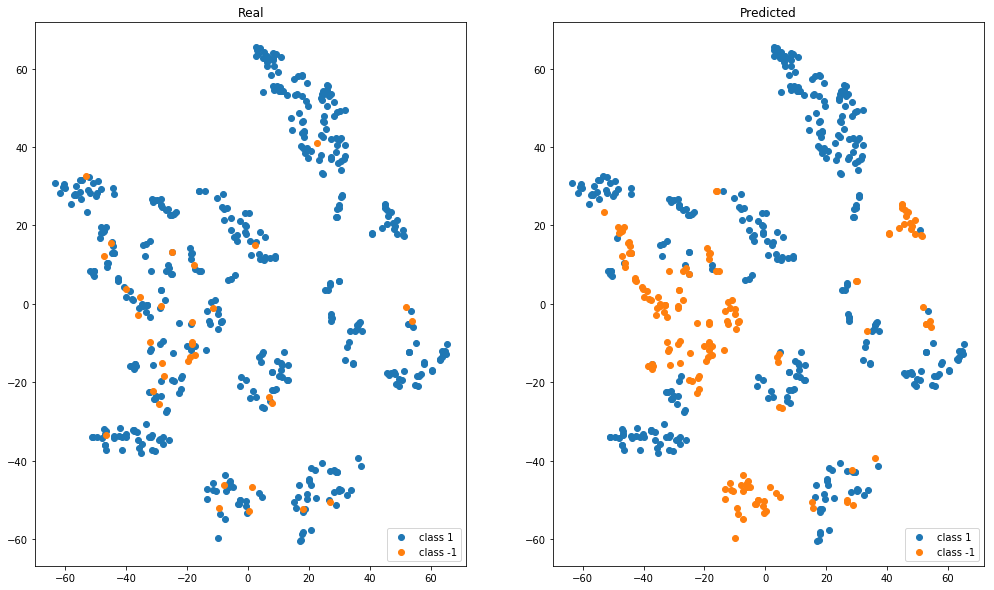

In [62]:
plot_real_vs_predicted(X_scaled_emb_test, y_test, y_ee_pred)